In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap


from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
# Helper functions for plotting
def plot_gaussian_hmm(hmm, params, emissions, states,  title="Emission Distributions", alpha=0.25):
    lim = 1.1 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    plt.figure()
    for k in range(hmm.num_states):
        lls = hmm.emission_distribution(params, k).log_prob(grid)
        plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape), cmap=white_to_color_cmap(COLORS[k]))
        plt.plot(emissions[states == k, 0], emissions[states == k, 1], "o", mfc=COLORS[k], mec="none", ms=3, alpha=alpha)

    plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=alpha)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title(title)
    plt.gca().set_aspect(1.0)
    plt.tight_layout()


def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None):
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True)
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title("Simulated data from an HMM")
    plt.tight_layout()

In [4]:
num_train_batches = 3
num_test_batches = 1
num_timesteps = 100

# Make an HMM and sample data and true underlying states
true_num_states = 5
emission_dim = 2
hmm = GaussianHMM(true_num_states, emission_dim)

# Specify parameters of the HMM
initial_probs = jnp.ones(true_num_states) / true_num_states
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, emission_dim - 2)),
    ])
emission_covs = jnp.tile(0.1**2 * jnp.eye(emission_dim), (true_num_states, 1, 1))
        
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Sample train, validation, and test data
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)
f = vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps))
train_true_states, train_emissions = f(jr.split(train_key, num_train_batches))
test_true_states,  test_emissions  = f(jr.split(test_key, num_test_batches))

In [44]:
jnp.shape(train_true_states)

(3, 100)

In [7]:
jnp.shape(train_emissions)

(3, 100, 2)

In [46]:
part1, part2, part3 = jnp.split(train_emissions, 3)
jnp.shape(jnp.concatenate([part1, part2, part3]))

In [48]:
jnp.shape(jnp.concatenate([part1, part2, part3]))

(3, 100, 2)

In [10]:
def cross_validate_model(model, key, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key, method="kmeans", emissions=train_emissions)
    
    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack([
        jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val):
        fit_params, train_lps = model.fit_em(params, props, y_train, 
                                             num_iters=num_iters, verbose=False)
        return model.marginal_log_prob(fit_params, y_val)

    val_lls = vmap(_fit_fold)(folds, train_emissions)
    return val_lls.mean(), val_lls

In [15]:
model = test_hmm
key = jr.PRNGKey(0)
num_iters = 100
params, props = model.initialize(key=key, method="kmeans", emissions=train_emissions)

# Split the training data into folds.
# Note: this is memory inefficient but it highlights the use of vmap.
folds = jnp.stack([
    jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
    for i in range(num_train_batches)
])

def _fit_fold(y_train, y_val):
    fit_params, train_lps = model.fit_em(params, props, y_train, 
                                            num_iters=num_iters, verbose=False)
    return model.marginal_log_prob(fit_params, y_val)

val_lls = vmap(_fit_fold)(folds, train_emissions)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
folds = jnp.stack([
    jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
    for i in range(num_train_batches)
])

In [30]:
for i in range(num_train_batches):
    print(i)

0
1
2


In [39]:
i = 0
a = jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
i = 1
b = jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
i = 2
c = jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
print(jnp.shape(a), jnp.shape(b), jnp.shape(c))
#jnp.shape(train_emissions[i+1:])

(2, 100, 2) (2, 100, 2) (2, 100, 2)


In [41]:
d = jnp.stack([a, b, c])
jnp.shape(d)

(3, 2, 100, 2)

In [29]:
[jnp.concatenate([train_emissions[:i], train_emissions[i+1:]]) for i in range(num_train_batches)]

[Array([[[ 0.93211055,  0.06626474],
         [ 0.35017994,  0.97471905],
         [-0.8109385 ,  0.54205   ],
         [-0.8012039 ,  0.6453685 ],
         [-0.755138  ,  0.69244266],
         [-0.6351679 ,  0.5151794 ],
         [-0.76603794,  0.5720403 ],
         [-0.7514261 , -0.6287814 ],
         [ 0.38578454, -1.0370821 ],
         [ 0.3504242 , -0.8789102 ],
         [ 0.17925929, -1.0578153 ],
         [ 0.36537975, -0.9969282 ],
         [ 0.20039067, -0.87923425],
         [ 0.34627926, -0.94474506],
         [ 0.45466286, -0.96497643],
         [ 0.3875742 , -0.9984174 ],
         [ 0.26486984, -0.96910775],
         [ 0.9818261 ,  0.0320369 ],
         [ 1.1291256 ,  0.13564382],
         [ 0.8702247 , -0.07361229],
         [ 0.9677579 , -0.0458537 ],
         [ 0.91111296,  0.17230994],
         [ 0.897957  , -0.0236588 ],
         [ 1.0202469 ,  0.07492431],
         [ 0.33328336,  0.97135323],
         [ 0.31660646,  0.9101343 ],
         [ 0.45949015,  0.93974507],
 

In [25]:
jnp.shape(folds)

(3, 2, 100, 2)

In [11]:
# Make a range of Gaussian HMMs
all_num_states = list(range(2, 10))
test_hmms = [GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
results = []
for test_hmm in test_hmms:
    print(f"fitting model with {test_hmm.num_states} states")
    results.append(cross_validate_model(test_hmm, jr.PRNGKey(0)))
    
avg_val_lls, all_val_lls = tuple(zip(*results))

fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'avg. validation log prob.')

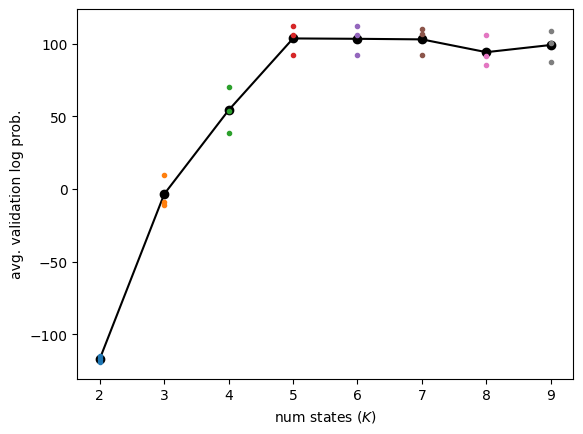

In [12]:
plt.plot(all_num_states, avg_val_lls, '-ko')
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")

In [ ]:
one = ONE()
example_session = 'cb2ad999-a6cb-42ff-bf71-1774c57e5308'

# Trials data
session_trials = one.load_object(example_session, obj='trials', namespace='ibl')
session_trials = session_trials.to_df()

# Licks
session_licks = get_lick_times(example_session, video_type = 'left')

# Wheel
wheel = one.load_object(example_session, 'wheel', collection='alf')
pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)



(-10.0, 10.0)

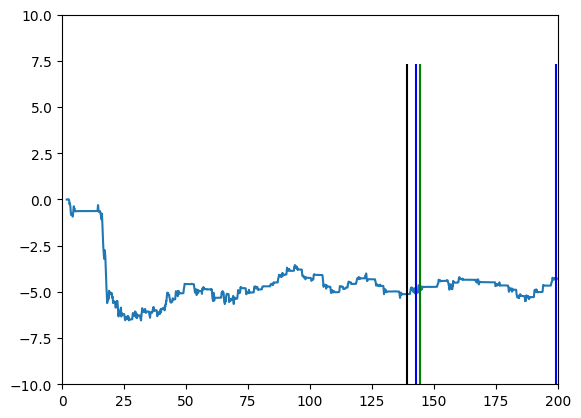

In [ ]:
plt.plot(wheel_times, pos)
plt.vlines(np.array(session_trials['goCue_times'] * 10), np.min(test_set) -.5, np.max(test_set) + .5, label='Stim On', color='Black')
plt.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10), np.min(test_set) -.5, np.max(test_set) + .5, label='Correct', color='Green')
plt.vlines(np.array(session_trials.loc[session_trials['feedbackType']==0, 'feedback_times'] * 10), np.min(test_set) -.5, np.max(test_set) + .5, label='Incorrect', color='Red')
plt.vlines(np.array(session_trials['firstMovement_times'] * 10), np.min(test_set) -.5, np.max(test_set) + .5, label='First movement', color='Blue')
plt.xlim([000, 200])
plt.ylim([-10, 10])

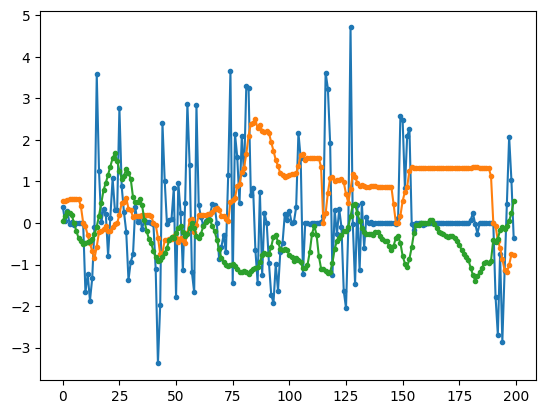

In [ ]:
plt.plot(test_set[200:400, :] , '-', marker='.')

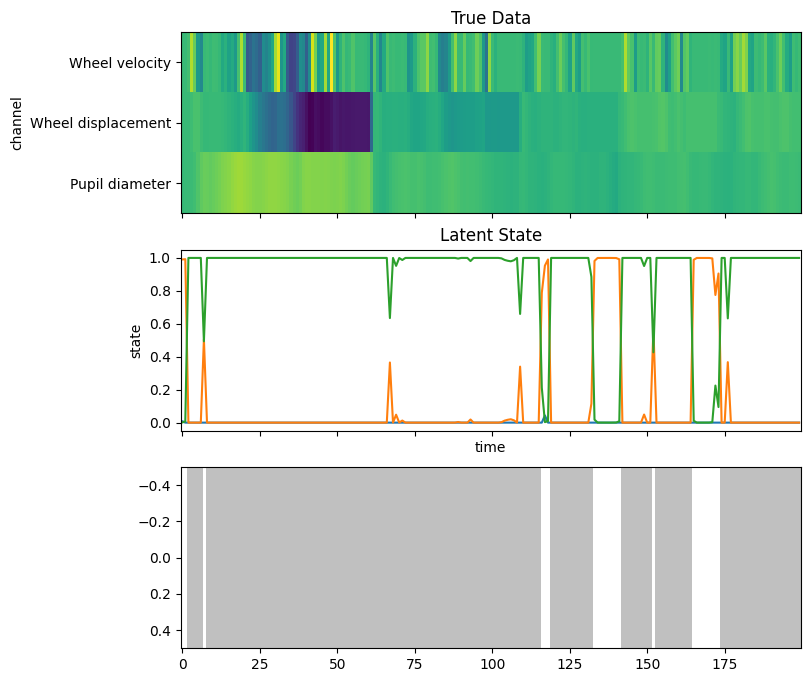

In [ ]:
# Posterior distribution
posterior = test_hmm.smoother(params, standardized_matrix[0:200])
Ez = posterior.smoothed_probs

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
axs[0].imshow(standardized_matrix[0:200].T, aspect="auto", interpolation="none")
axs[0].set_ylabel("channel")
axs[0].set_title("True Data")
axs[1].plot(Ez)
axs[2].imshow(
    most_likely_states[None, 0:200],
    aspect="auto",
    cmap="Greys",
    alpha=0.25)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")

axs[0].set_yticks([0, 1, 2], ['Wheel velocity', 'Wheel displacement', 'Pupil diameter'])
plt.show()



In [ ]:
most_likely_states[None, :]

Array([[1, 1, 2, ..., 2, 2, 2]], dtype=int32)

Text(0, 0.5, 'log likelihood')

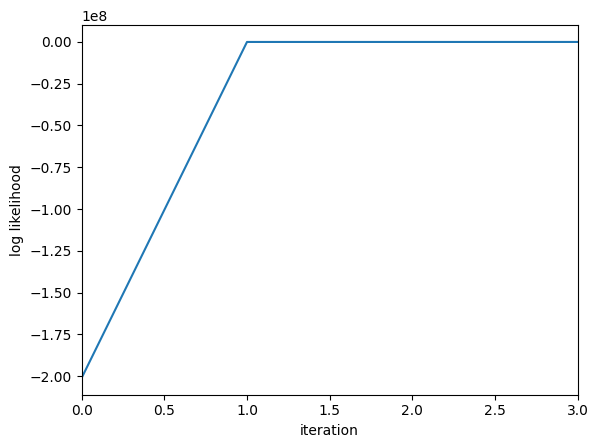

In [ ]:
# Plot the log probabilities
plt.plot(lps)
plt.xlim([0,3])
plt.xlabel("iteration")
plt.ylabel("log likelihood")

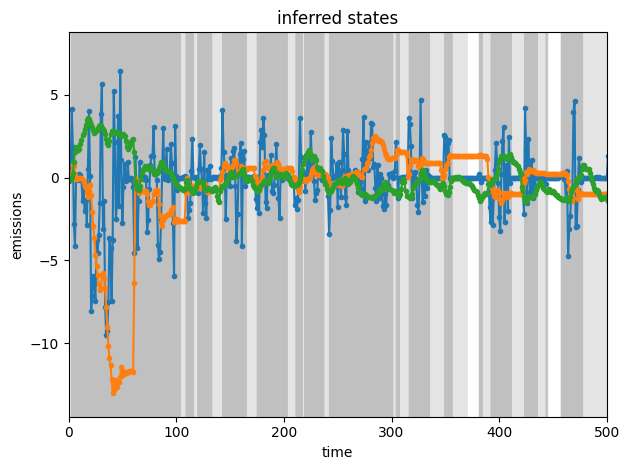

In [ ]:
# Compute the most likely states
most_likely_states = test_hmm.most_likely_states(params, standardized_matrix)

# Compare them to the true states
fig, axs = plt.subplots(1, 1, sharex=True)

for i, states in enumerate([most_likely_states]):
    offsets = 3 * jnp.arange(emission_dim)
    axs.imshow(
        states[None, :],
        extent=(0, num_timesteps, np.min(standardized_matrix) -.5, np.max(standardized_matrix) + .5),
        aspect="auto",
        cmap="Greys",
        alpha=0.25)
    #axs.plot(standardized_matrix + offsets, '-', marker='.')
    axs.plot(standardized_matrix , '-', marker='.')
    axs.set_xlim(0, num_timesteps)
    axs.set_ylim(-3, 3 * emission_dim)
    axs.set_ylim(np.min(standardized_matrix) -.5, np.max(standardized_matrix) + .5)
    axs.set_ylabel("emissions")
    axs.set_xlabel("time")
    axs.set_xlim(0, 500)

axs.set_title("inferred states")
plt.tight_layout()

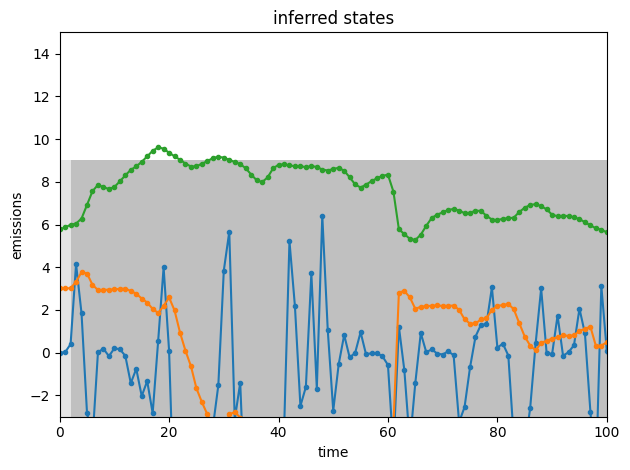

In [ ]:
# Compute the most likely states
most_likely_states = test_hmm.most_likely_states(params, standardized_matrix)

# Compare them to the true states
fig, axs = plt.subplots(1, 1, sharex=True)

for i, states in enumerate([most_likely_states]):
    offsets = 3 * jnp.arange(emission_dim)
    axs.imshow(
        states[None, :],
        extent=(0, num_timesteps, -3, 3 * emission_dim),
        aspect="auto",
        cmap="Greys",
        alpha=0.25)
    axs.plot(standardized_matrix + offsets, '-', marker='.')
    axs.set_xlim(0, num_timesteps)
    axs.set_ylim(-3, 3 * emission_dim)
    axs.set_ylim(-3,15)
    axs.set_ylabel("emissions")
    axs.set_xlabel("time")
    axs.set_xlim(0, 100)

axs.set_title("inferred states")
plt.tight_layout()
